# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
import pickle
from nltk.stem.porter import PorterStemmer
import pickle

nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])
nltk.download('stopwords')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to /Users/Markus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Markus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Markus/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Markus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# load data from database
engine = create_engine('sqlite:///data/DisasterResponse.db')
df = pd.read_sql("SELECT * FROM DisasterMessages", engine)

In [4]:
X = df['message']
y = df.loc[:,'related':'direct_report']

In [6]:
y['related'].unique()

array([1, 0])

In [7]:
y['related'].replace(2, 1, inplace=True)

In [8]:
y.drop(columns='child_alone', inplace=True)

In [9]:
category_names = y.columns

In [10]:
len(category_names)

35

### 2. Write a tokenization function to process your text data

In [16]:
def tokenize(text):
    
    # extrac text based on the pattern
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    
    # get tokens and remove stopwords
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stopwords.words("english")]
    
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [12]:
# standard pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(n_jobs=-2, random_state=42)))
    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [14]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                 MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                  

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [15]:
X_test.shape

(6554,)

In [16]:
X_train.shape

(19661,)

In [17]:
y_test.shape

(6554, 35)

In [18]:
y_train.shape

(19661, 35)

In [19]:
y_pred = pipeline.predict(X_test)

In [25]:
y_pred.shape, y_test.shape

((6554, 35), (6554, 35))

In [22]:
y_pred_df = pd.DataFrame(data=y_pred, index=y_test.index, columns=y_test.columns)

In [41]:
y_test['hospitals'].value_counts()

0    6494
1      60
Name: hospitals, dtype: int64

In [42]:
y_pred_df['hospitals'].value_counts()

0    6552
1       2
Name: hospitals, dtype: int64

In [40]:
print(classification_report(y_test['hospitals'], y_pred_df['hospitals']))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6494
           1       0.00      0.00      0.00        60

    accuracy                           0.99      6554
   macro avg       0.50      0.50      0.50      6554
weighted avg       0.98      0.99      0.99      6554



In [39]:
print(classification_report(y_test, y_pred_df, target_names=category_names))

                        precision    recall  f1-score   support

               related       0.85      0.92      0.88      5001
               request       0.80      0.45      0.57      1093
                 offer       0.00      0.00      0.00        32
           aid_related       0.76      0.59      0.67      2700
          medical_help       0.64      0.08      0.15       532
      medical_products       0.68      0.09      0.15       345
     search_and_rescue       0.46      0.04      0.07       165
              security       1.00      0.01      0.02       127
              military       0.48      0.07      0.12       197
                 water       0.90      0.36      0.51       408
                  food       0.82      0.47      0.60       723
               shelter       0.80      0.28      0.42       590
              clothing       0.73      0.08      0.15        95
                 money       0.64      0.07      0.12       138
        missing_people       1.00      

In [ ]:
y_test['tools'].value_counts()

In [ ]:
y_test.shape

In [ ]:
y_pred.shape

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
y_pred_df = pd.DataFrame(data=y_pred, index=y_test.index, columns=y_test.columns)

In [ ]:
print(classification_report(y_test, y_pred_df, target_names=category_names))

In [ ]:
# calculate the overall accurace
# with the first mean you get the mean for each columns
# and with the second mean over each column 
overall_accuracy = (y_pred == y_test).mean().mean()

In [ ]:
overall_accuracy

### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
pipeline.get_params().keys()

In [ ]:
#cv = RandomizedSearchCV(
#    estimator=pipeline, param_distributions = random_grid, n_iter = 10, verbose=10, random_state=42, n_jobs = -1,
#    scoring='accuracy')

I wanted to do a RondomizedSerachCV to get the best hyperparamaters and than do a GridSerach again with slightly altered paramaters to geht the best model, but it took forever so now to demonstraste I will run a fairly simple GridSerach:

In [ ]:
# parameters = {'clf__estimator__n_estimators': [50, 100],
#              'clf__estimator__min_samples_split': [2, 4],
#              'clf__estimator__criterion': ['entropy', 'gini']
#                 }
# cv = GridSearchCV(pipeline, param_grid=parameters, n_jobs=-2, verbose=10)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
classifier = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2, n_jobs=-1)

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(classifier))
    ])

In [ ]:
pipeline.fit(X_train,y_train)

In [ ]:
cv.best_params_

In [ ]:
cv.best_estimator_

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
overall_accuracy = (y_pred == y_test).mean().mean()
overall_accuracy

In [ ]:
y_pred_df = pd.DataFrame(data=y_pred, index=y_test.index, columns=category_names)

In [ ]:
print(classification_report(y_test, y_pred_df, target_names=category_names))

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [ ]:
y_train['child']

In [46]:
from sklearn.linear_model import LogisticRegression

In [47]:
# lets test logictic regression

pipeline_log= Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(LogisticRegression()))
    ])

# pipeline_log.fit(X_train, y_train)

In [ ]:
evaluate(pipeline_log, X_test, y_test, category_names)

In [49]:
pipeline_log.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf__estimator__C', 'clf__estimator__class_weight', 'clf__estimator__dual', 'clf__estimator__fit_intercept', 'clf__estimator__intercept_scaling', 'clf__estimator__l1_ratio', 'clf__estimator__max_iter', 'clf__estimator__multi_class', 'clf__estimator__n_jobs', 'clf__estimator__penalty', 'clf__estimator__random_state', 'clf__estimator__solver', 'clf__estimator__tol', 'clf__estimator__verbose', 'clf__estimator__warm_start', 'clf__estimator', 'clf__n_jobs'])

In [62]:
parameters= {'clf__estimator__C': [0.01, 0.1, 1, 10, 100],
              'clf__estimator__solver': ['saga', 'lbfgs'],
                 }
cv = GridSearchCV(pipeline_log, param_grid=parameters, n_jobs=-1, verbose=10, cv=3)

In [63]:
cv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 21.3min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 23.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [66]:
best_params = cv.best_params_

In [67]:
best_params

{'clf__estimator__C': 10, 'clf__estimator__solver': 'saga'}

slightly higher averall accuracy and weighted f1 avg 

### 9. Export your model as a pickle file

In [ ]:
filename = 'classifier.pkl'
pickle.dump(pipeline, open(filename, 'wb'))

# load file
# loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
load_model = pickle.load((open('classifier.pkl', 'rb')))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

### 11. Visualizations for the web app

In [3]:
df.loc[:, 'related':'direct_report'].columns

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')

In [6]:
df.loc[:, 'related':'direct_report'].sum().values

array([20093,  4474,   118, 10860,  2084,  1313,   724,   471,   860,
           0,  1672,  2923,  2314,   405,   604,   298,   875,  1194,
        3446,  1705,  1201,  1333,   532,   159,   283,   120,   309,
        1151,  7297,  2155,  2443,   282,  2455,   530,  1376,  5075])

In [10]:
df['message'].apply(len)

0         66
1         39
2         31
3        100
4         63
        ... 
26210    148
26211    136
26212    141
26213    191
26214    209
Name: message, Length: 26215, dtype: int64

In [11]:
df['len_message'] = df['message'].apply(len)

In [106]:
len_messages = df['len_message']

In [29]:
df['len_message'].sort_values()

12205        4
22707        6
21719        6
22497        6
16531        6
         ...  
24809     6510
25100     6936
19391     6951
16031    10571
20843    10818
Name: len_message, Length: 26215, dtype: int64

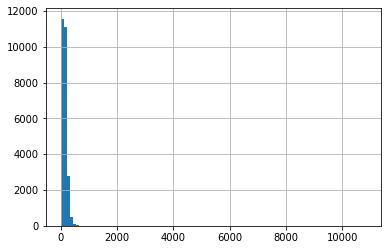

In [105]:
import matplotlib.pyplot as plt
df['len_message'].hist(bins=100)

In [42]:
text = df['message']

In [45]:
text = text.to_list()

In [53]:
text = [sub.replace(r"[^a-zA-Z0-9]", " ") for sub in text]

In [56]:
tokens = [word_tokenize(x) for x in text]

In [58]:
tokens = [w for w in tokens if w not in stopwords.words('english')]

In [72]:
len_tokens = []
for count, sent in enumerate(tokens):
    sent_len = len(tokens[count])
    len_tokens.append(sent_len)

In [94]:
from plotly.express import histogram

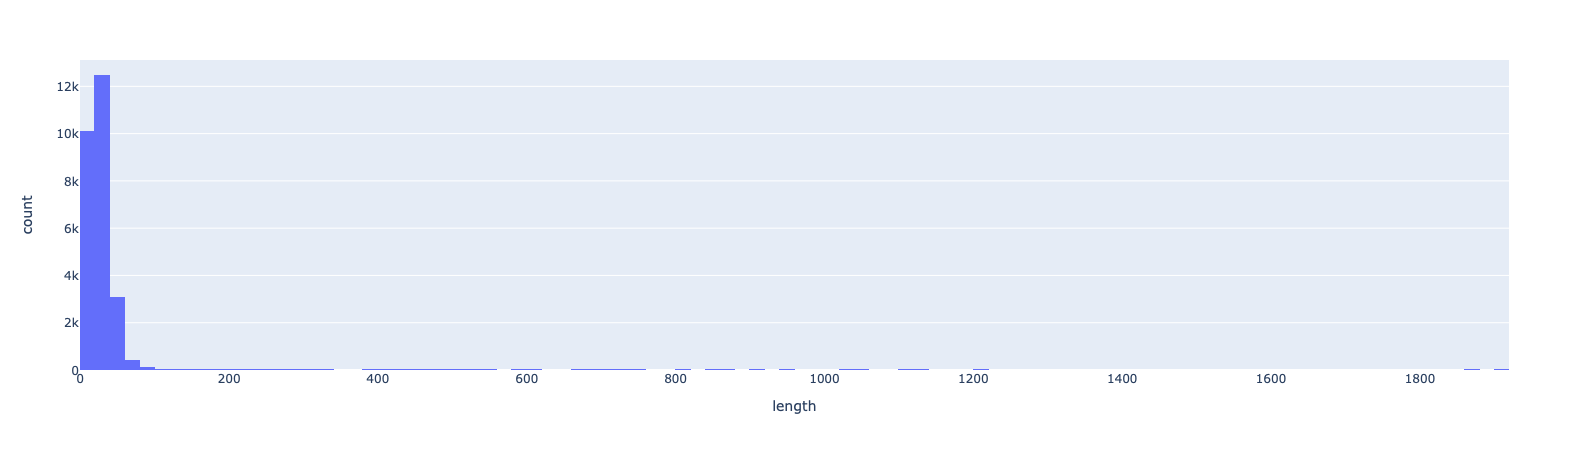

In [101]:
histogram(data_frame=len_token_df, x='length', nbins=100)

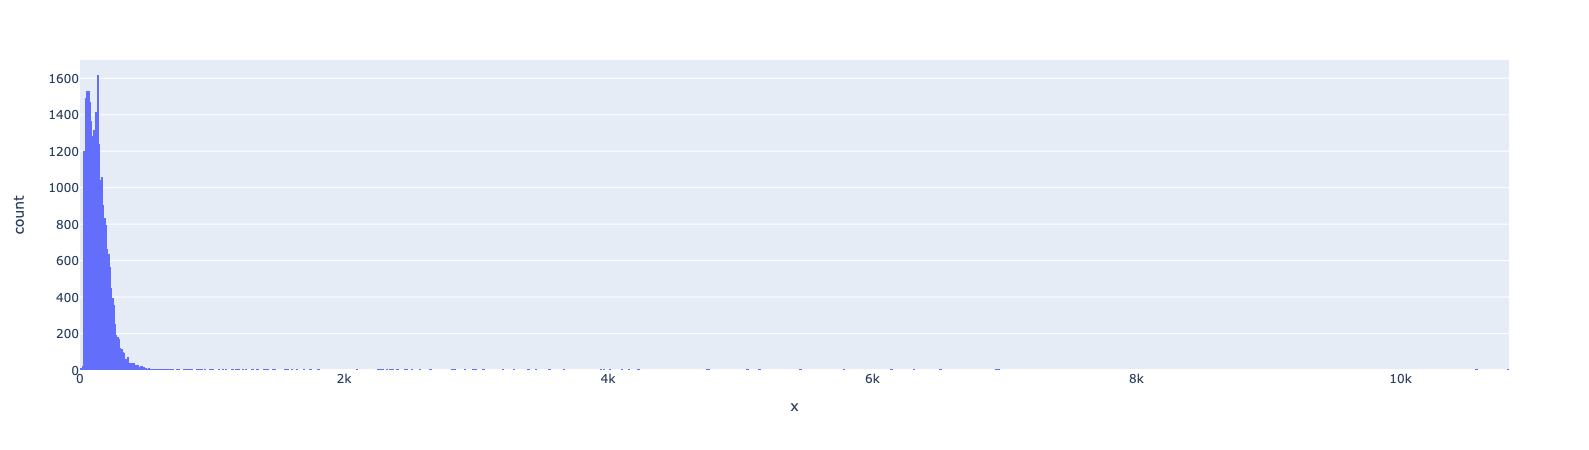

In [107]:
histogram(x=len_messages)

In [108]:
from plotly.graph_objs import Histogram

In [112]:
Histogram(x=len_messages, nbinsx=100)

Histogram({
    'nbinsx': 100, 'x': array([ 66,  39,  31, ..., 141, 191, 209])
})